In [2]:
from __future__ import print_function
import time, os, json
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt

from util import *
from model.video_caption import sequence_2_sequence_LSTM
from model.image_caption import image_caption_LSTM

from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Build Model

In [3]:
#=======Change These===============================
max_train = 10000
word_vector_size = 50
#==================================================


data = load_coco_data(pca_features = False, max_train = max_train)
input_size = data['train_features'].shape[1]
maxLen = data['train_captions'].shape[1]
wordLs = []

for caption in data['train_captions']:
    for word in caption:
        wordLs.append(word)
voc_size = len(list(set(wordLs)))

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))
print('\ninput_size:', input_size, ' maxLen:', maxLen, ' voc_size:', voc_size)
print('Finish loading training data!')

train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
word_to_idx <class 'dict'> 1004
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_captions <class 'numpy.ndarray'> (10000, 17) int32
train_image_idxs <class 'numpy.ndarray'> (10000,) int32
idx_to_word <class 'list'> 1004

input_size: 4096  maxLen: 17  voc_size: 1004
Finish loading training data!


In [6]:
# create word2ind and ind2word dictionary
index2Word_ori = data['idx_to_word']
word2Index_ori = data['word_to_idx']

wordLs = sorted(list(set(wordLs)))
word2index = {}
index2word = {}
for i, word_ind in enumerate(wordLs):
    word = index2Word_ori[word_ind]
    word2index[word] = i
    index2word[i] = word
print('finish building dictionary')

finish building dictionary


build model

In [7]:
captions_train = {}
captions_corresponding_videoIds = []
input_frames_train = {}

captions_corresponding_videoIds = data['train_image_idxs']
for i, ind in enumerate(data['train_image_idxs']):
    caption = data['train_captions'][i]
    caption_new = []
    for word_ind in caption:
        word = index2Word_ori[word_ind]
        caption_new.append( word2index[word] )
        
    captions_train[ind] = list(caption_new)
    input_frames_train[ind] = data['train_features'][ind].reshape(1, input_size)

word_embedding = np.random.randn(voc_size, word_vector_size).astype(np.float32)

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [15]:
# define parameters
logging.basicConfig(level=logging.INFO)
#=======Change These===============================
state_size = 1024
#==================================================

tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("max_sentence_length", 17, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_vector_size, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("num_frames", 1, "number of frames per video")
FLAGS = tf.app.flags.FLAGS        

In [16]:
# build model graph
tf.reset_default_graph()
#=======Change These===============================
batch_size = 64
epoch = 10
lr = 5e-4
hidden_size = 1024
#==================================================

model = image_caption_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
        voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-3, mode = 'train', save_model_file = 'COCO')

# model = sequence_2_sequence_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
#         voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-3, mode = 'train', save_model_file = 'COCO')


model.train_embedding = True
model.build()

start building model ...
total number of parameter 26470404


In [ ]:
# check variables
for v in tf.trainable_variables():
    print(v)

9473
7578
120/118 [==============================] - 25s - train loss: 4.3553


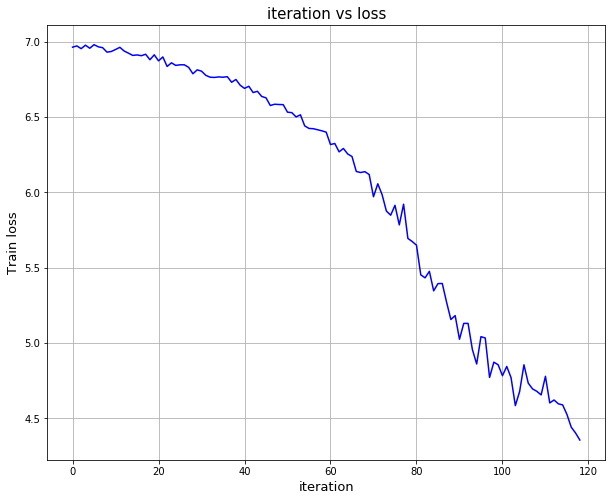

 1/10 [==>...........................] - ETA: 305s - train loss: 6.0356 - dev loss: 4.4420 
Validation loss improved, Save Model!
120/118 [==============================] - 24s - train loss: 2.4994


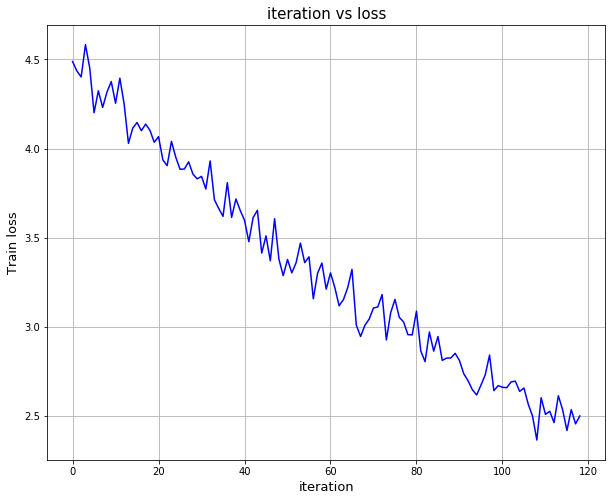

 2/10 [=====>........................] - ETA: 267s - train loss: 3.3324 - dev loss: 2.4187 
Validation loss improved, Save Model!
120/118 [==============================] - 26s - train loss: 1.1383


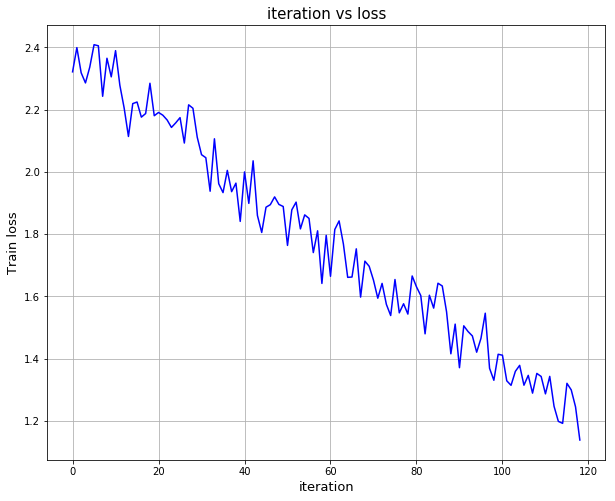

 3/10 [========>.....................] - ETA: 249s - train loss: 1.7824 - dev loss: 1.2609 
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.6107


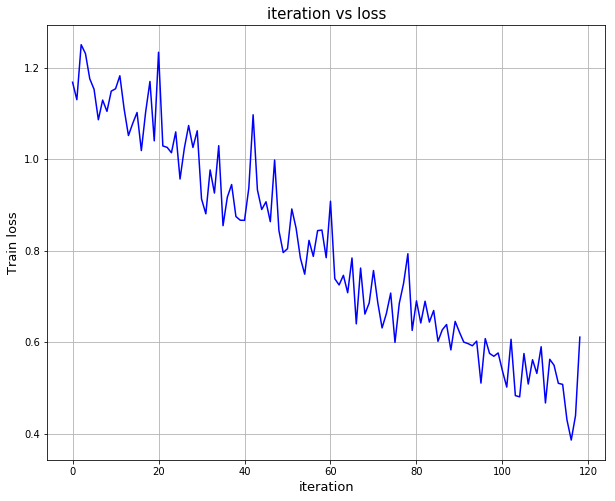

 4/10 [===========>..................] - ETA: 270s - train loss: 0.8059 - dev loss: 0.5078 
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.1690


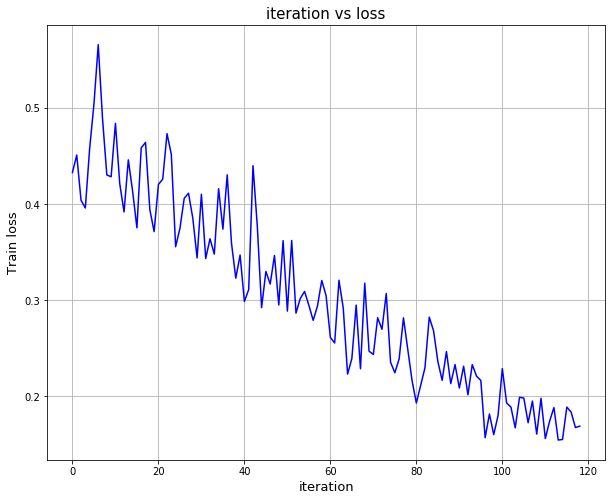

 5/10 [==============>...............] - ETA: 252s - train loss: 0.3021 - dev loss: 0.2002 
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.0703


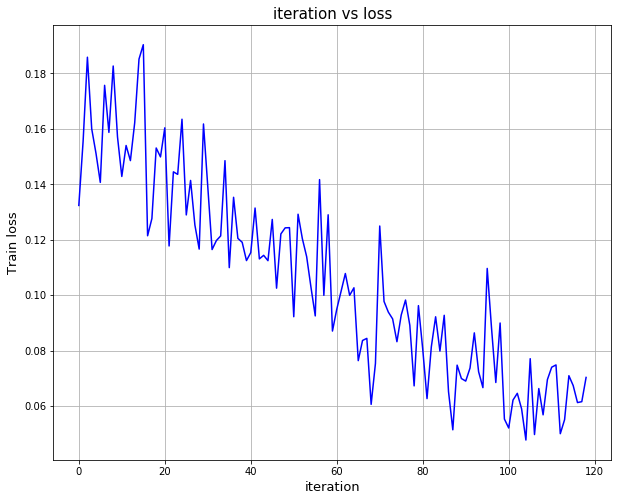

 6/10 [=================>............] - ETA: 216s - train loss: 0.1061 - dev loss: 0.0731 
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.0156


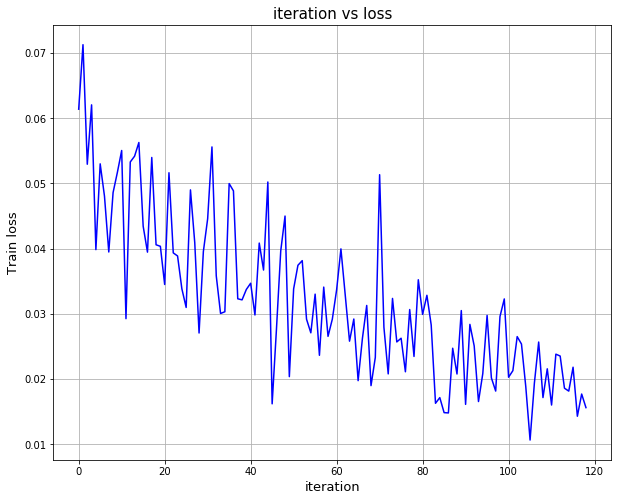

 7/10 [====================>.........] - ETA: 170s - train loss: 0.0323 - dev loss: 0.0272 
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.0049


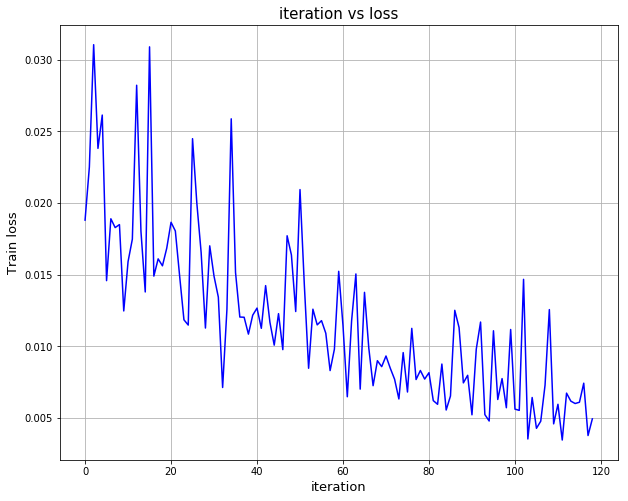

 8/10 [=======================>......] - ETA: 117s - train loss: 0.0118 - dev loss: 0.0118 
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.0017


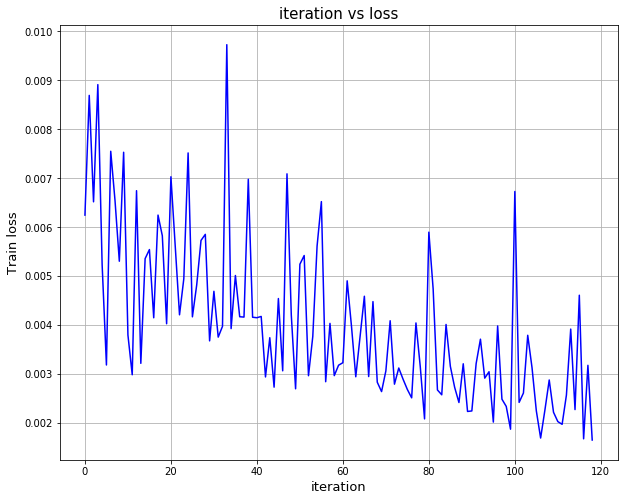

 9/10 [==========================>...] - ETA: 60s - train loss: 0.0040 - dev loss: 0.0067  
Validation loss improved, Save Model!
120/118 [==============================] - 58s - train loss: 0.0021


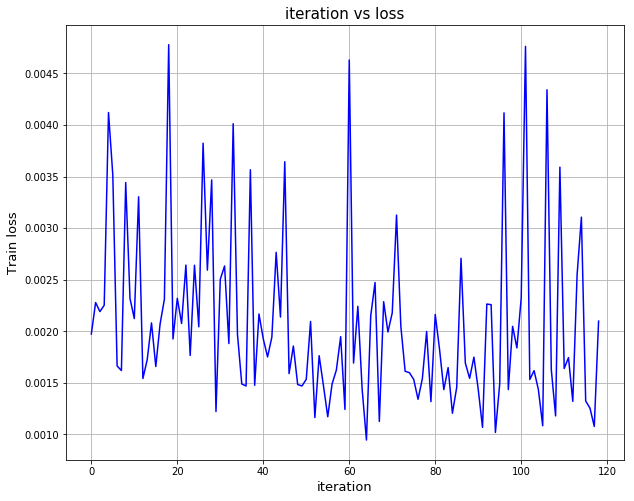

10/10 [==============================] - 614s - train loss: 0.0021 - dev loss: 0.0042    
 
Validation loss improved, Save Model!


In [36]:
# run training mode
# saver = tf.train.Saver()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)


In [37]:
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

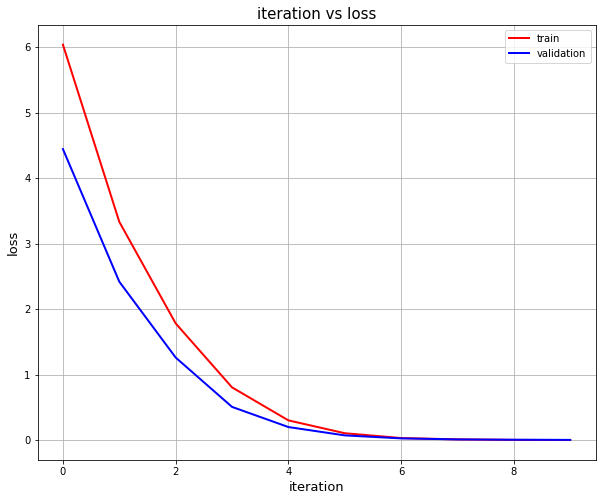

In [38]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/CoCo_image_caption_learning_curve.png')
# plt.savefig(os.getcwd() + '/output/CoCo_seq2seq_learning_curve.png')

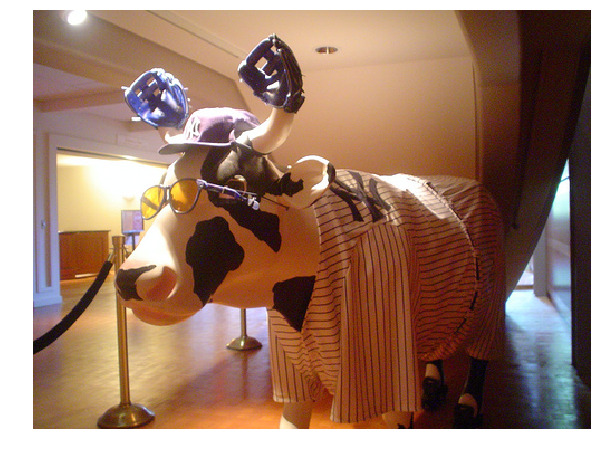

Pred Caption:  <START> <UNK> cow wearing baseball uniform and yellow sunglasses on display <END>
True Caption:  <START> <UNK> cow wearing baseball uniform and yellow sunglasses on display <END>
--------------------------------------------------


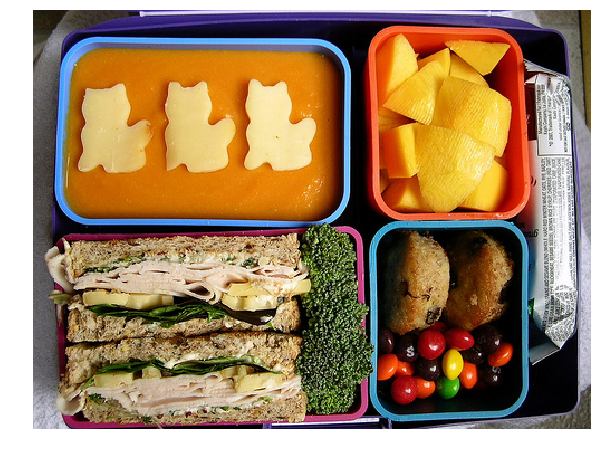

Pred Caption:  <START> a purple tray with four different types of food <END>
True Caption:  <START> a purple tray with four different types of food <END>
--------------------------------------------------


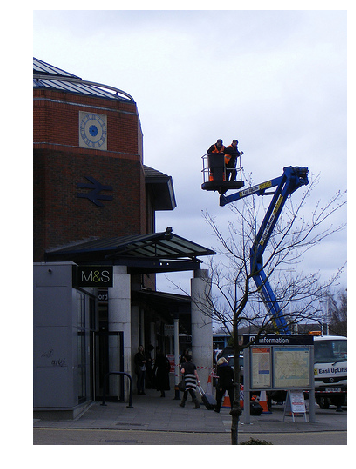

Pred Caption:  <START> two men making <UNK> on a blue <UNK> <UNK> <END>
True Caption:  <START> two men making <UNK> on a blue <UNK> <UNK> <END>
--------------------------------------------------
Pred Caption:  <START> a silver fire hydrant that is <UNK> water <END>
True Caption:  <START> a silver fire hydrant that is <UNK> water <END>
--------------------------------------------------
Pred Caption:  <START> a small plain kitchen with a white stove and microwave <END>
True Caption:  <START> a small plain kitchen with a white stove and microwave <END>
--------------------------------------------------
Pred Caption:  <START> a child is holding an orange umbrella in a shower <END>
True Caption:  <START> a child is holding an orange umbrella in a shower <END>
--------------------------------------------------
Pred Caption:  <START> a skateboarder <UNK> to <UNK> a trick above land <END>
True Caption:  <START> a skateboarder <UNK> to <UNK> a trick above land <END>
----------------------------

In [39]:
# list_video_index, list_predict_index = out

captions = captions_train
train_urls = data['train_urls']
# caption check
for j in range(len(val_pred)):
    words = []
    trues = []
    sample = val_pred[j]
    vid = val_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2word[i]
        true = index2word[cap[idx]]
        
        if word not in ['<NULL>']:
            words.append(word)
        if true not in ['<NULL>']:
            trues.append(true) 
        
    if j<3: 
        url = train_urls[int(vid)]
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

# TestSet

val_features....\class 'numpy.ndarray'\....   (40504, 4096) float32  
val_captions....\class 'numpy.ndarray'\....   (195954, 17) int32   
val_image_idxs....\<class 'numpy.ndarray'\....   (195954,) int32   
val_urls class....\'numpy.ndarray'\....   (40504,) <U63   

train_features....\class 'numpy.ndarray'\....   (82783, 4096) float32    
train_captions....\class 'numpy.ndarray'\....   (1000, 17) int32   
train_image_idxs....\class 'numpy.ndarray'\....   (1000,) int32   
train_urls....\class 'numpy.ndarray'\....   (82783,) <U63      

idx_to_word....\class 'list'\....   1004   
word_to_idx....\class 'dict'\....   1004   


In [11]:
val_features = data['val_features']
val_captions = data['val_captions']
val_image_idxs = data['val_image_idxs']
val_urls = data['val_urls']

# Extract test set 
n = 5
val_features_dict = {}
val_captions_dict = {}
val_urls_dict = {}
val_image_idxs_dictKeys = []

# for i,vid in enumerate(val_image_idxs):
#     if i>=n: break
#     val_captions_dict[vid] = val_captions[i]
#     val_features_dict[vid] = val_features[vid].reshape((1,-1))
#     val_urls_dict[vid] = val_urls[vid]
#     val_image_idxs_dictKeys.append(vid)

for i,vid in enumerate(val_image_idxs):
    if i>=n: break
    vid_pseudo = val_image_idxs[n-1-i]
    
    val_captions_dict[vid] = val_captions[i]
    val_features_dict[vid] = val_features[vid_pseudo].reshape((1,-1))
    val_urls_dict[vid] = val_urls[vid_pseudo]
    val_image_idxs_dictKeys.append(vid)


# Predict testset

In [17]:
with get_session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, os.getcwd() + "/model/COCO.ckpt")
    model.mode = 'test'
    out = model.predict(sess, val_features_dict, val_captions_dict)

INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/COCO.ckpt


INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/COCO.ckpt
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


In [18]:
list_video_index, list_predict_index = out

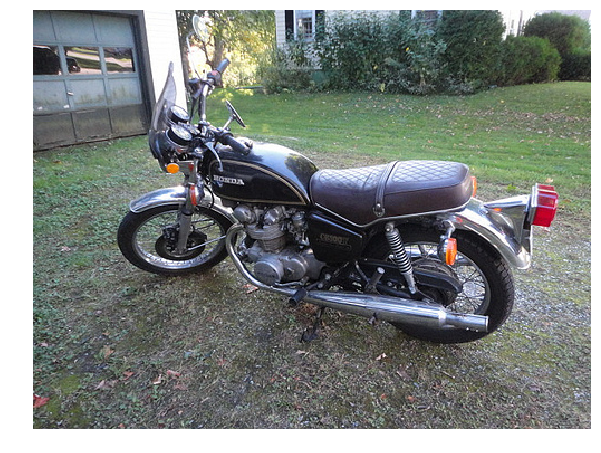

Pred Caption:  <START> a car that <UNK> to be parked <UNK> behind a <UNK> parked car <END>
true Caption:  <START> a car that <UNK> to be parked <UNK> behind a <UNK> parked car <END>
--------------------------------------------------


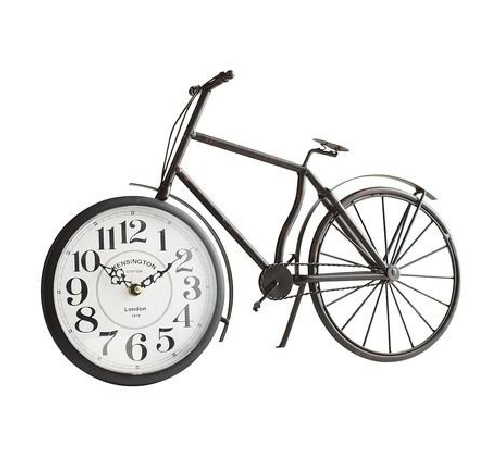

Pred Caption:  <START> a large passenger airplane flying through the air <END>
true Caption:  <START> a large passenger airplane flying through the air <END>
--------------------------------------------------


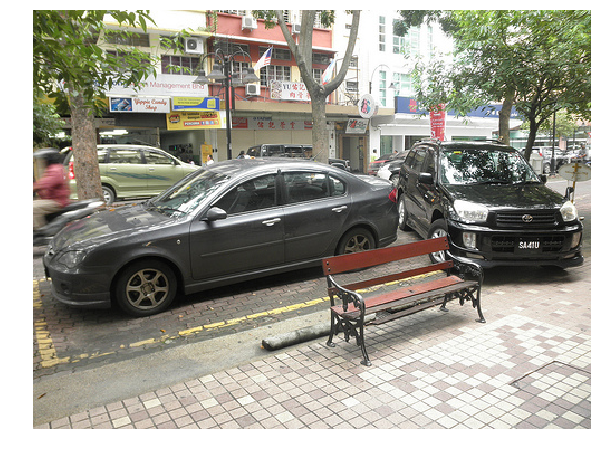

Pred Caption:  <START> a black <UNK> motorcycle parked in front of a <UNK> <END>
true Caption:  <START> a black <UNK> motorcycle parked in front of a <UNK> <END>
--------------------------------------------------


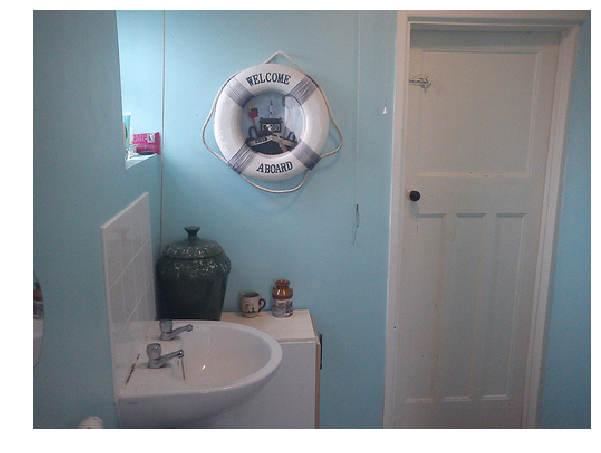

Pred Caption:  <START> a room with blue walls and a white sink and door <END>
true Caption:  <START> a room with blue walls and a white sink and door <END>
--------------------------------------------------


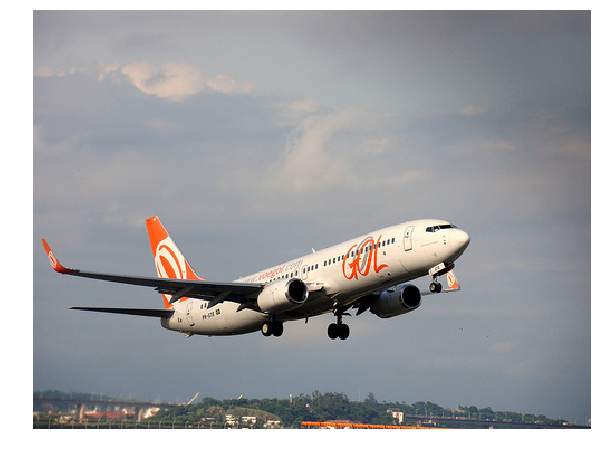

Pred Caption:  <START> a bicycle <UNK> with a clock as the front <UNK> <END>
true Caption:  <START> a bicycle <UNK> with a clock as the front <UNK> <END>
--------------------------------------------------


In [19]:
for i, v_id in enumerate( list_video_index ):
    url = val_urls_dict[v_id]

    caption_pre = []
    for ind in list_predict_index[0][i]:
        word = index2word[ind]       
        if word not in ['<NULL>']:
            caption_pre.append(word)
            
    caption_true = []
    for ind in val_captions_dict[v_id]:
        word = index2word[ind]       
        if word not in ['<NULL>']:
            caption_true.append(word)
            
            
    plt.imshow(image_from_url(url))
    plt.axis('off')
    plt.show()
    print('Pred Caption: ', ' '.join(w for w in caption_pre))
    print('true Caption: ', ' '.join(w for w in caption_true))

    print('-'*50)



# Look At Data

In [ ]:


url = train_urls[vid]
plt.imshow(image_from_url(url))
plt.axis('off')
caption_str = decode_captions(caption, data['idx_to_word'])
plt.title(caption_str)
plt.show()

# # Sample a minibatch and show the images and captions
# batch_size = 1
# captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
# for i, (caption, url) in enumerate(zip(captions, urls)):
#     plt.imshow(image_from_url(url))
#     plt.axis('off')
#     caption_str = decode_captions(caption, data['idx_to_word'])
#     plt.title(caption_str)
#     plt.show()